In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import date,datetime,timedelta
from math import floor

from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout

plt.style.use('fivethirtyeight')

In [2]:
# Historical data for 500days

def stock_data_all(ticker):
    # start_date1 = date.today()
    end_date1 = date.today()-timedelta(days=5000)
    # start_date = start_date1.strftime("%Y-%m-%d")
    end_date = end_date1.strftime("%Y-%m-%d")

    # Request data:
    data = yf.download(ticker,
                        end_date)
    
    return data

In [3]:
stock_df = stock_data_all('SPY')

[*********************100%***********************]  1 of 1 completed


In [4]:
data = stock_df[['Open','High','Low','Adj Close','Volume']]
data = data.rename(columns={'Adj Close': 'Close'}, inplace=False)
data.shape

(3447, 5)

In [5]:
# Convert dataframe to numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

2758

In [6]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

scaled_data.shape

(3447, 5)

In [7]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0: training_data_len, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0:data.shape[1]])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

x_train shape == (2698, 60, 5).
y_train shape == (2698,).


In [8]:
y_train

array([0.16419152, 0.16385903, 0.18433448, ..., 0.62282499, 0.61850271,
       0.61437439])

In [9]:
# Build the LSTM model
model = Sequential()

model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

# model.add(Dense(y_train.shape[1]))
model.add(Dense(25))
model.add(Dense(1))

# Complile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                825       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,187
Trainable params: 31,187
Non-trainable params: 0
_________________________________________________________________


In [10]:
# fit model
model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/50
152/152 [==============================] - 11s 42ms/step - loss: 0.0045 - val_loss: 1.9775e-04
Epoch 2/50
152/152 [==============================] - 6s 39ms/step - loss: 8.6913e-04 - val_loss: 3.8373e-04
Epoch 3/50
152/152 [==============================] - 6s 41ms/step - loss: 7.1355e-04 - val_loss: 1.3093e-04
Epoch 4/50
152/152 [==============================] - 7s 43ms/step - loss: 5.7224e-04 - val_loss: 9.8052e-05
Epoch 5/50
152/152 [==============================] - 7s 45ms/step - loss: 5.6703e-04 - val_loss: 4.4657e-04
Epoch 6/50
152/152 [==============================] - 7s 45ms/step - loss: 5.2852e-04 - val_loss: 9.7769e-05
Epoch 7/50
152/152 [==============================] - 7s 46ms/step - loss: 4.8293e-04 - val_loss: 0.0010
Epoch 8/50
152/152 [==============================] - 7s 45ms/step - loss: 5.3369e-04 - val_loss: 2.1018e-04
Epoch 9/50
152/152 [==============================] - 7s 45ms/step - loss: 5.0312e-04 - val_loss: 0.0012
Epoch 10/50
152/152 [=========

In [11]:
# Create the testing data set
# Create a new array containing scaled values form index 1021 to 1276
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0:data.shape[1]])
y_test.shape

(689, 5)

In [12]:
# Convert the data to numpy array
x_test = np.array(x_test)

In [13]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))
x_test.shape

(689, 60, 5)

In [14]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = np.repeat(predictions, data.shape[1], axis=-1)
predictions = scaler.inverse_transform(predictions)
predictions_df = pd.DataFrame(predictions, columns = ['Open','High','Low','Close','Volume'])

predictions_1 = predictions[:,3]

predictions_df

,Open,High,Low,Close,Volume
0,282.650421,286.592133,283.288666,279.541779,526359296.0
1,282.001709,285.937714,282.635468,278.857758,524830176.0
2,281.666321,285.599365,282.297760,278.504120,524039616.0
3,278.785614,282.693268,279.397064,275.466614,517249216.0
4,274.501434,278.371338,275.083221,270.949249,507150624.0
...,...,...,...,...,...
684,413.943054,419.041534,415.491364,417.980591,835840704.0
685,415.025818,420.133850,416.581635,419.122253,838392960.0
686,416.372131,421.492035,417.937317,420.541901,841566528.0
687,416.836212,421.960205,418.404602,421.031189,842660416.0


In [15]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:].reset_index()
valid['Predictions'] = predictions_1
valid = valid.set_index('Date')
valid


,Open,High,Low,Close,Volume,Predictions
Date,,,,,,
2018-10-08,287.049988,288.220001,285.500000,273.886902,87742200,279.541779
2018-10-09,287.390015,288.859985,286.769989,273.487183,74339000,278.857758
2018-10-10,286.829987,286.910004,277.880005,264.827728,214731000,278.504120
2018-10-11,277.079987,278.899994,270.359985,258.994507,274840500,275.466614
2018-10-12,276.769989,277.089996,272.369995,262.591522,183186500,270.949249
...,...,...,...,...,...,...
2021-06-28,427.170013,427.649994,425.890015,427.470001,53159600,417.980591
2021-06-29,427.880005,428.559998,427.130005,427.700012,35970500,419.122253
2021-06-30,427.209991,428.779999,427.179993,428.059998,64827900,420.541901


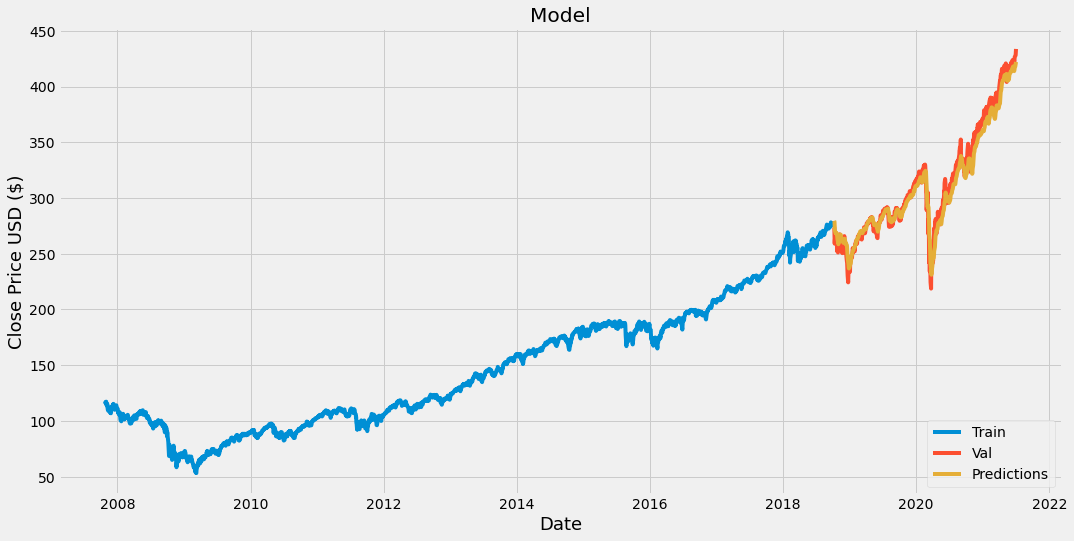

In [16]:
# Visualise the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train','Val','Predictions'], loc= 'lower right')

In [17]:
# Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions[:,3]- y_test[:,3])**2)))
rmse

8.219161563482919